# INFO284 ML - Group assignment
#### Cand.nr: 250, 

## Table of contents

<a name='task1'></a>
# Task 1

### Imports for task 1

In [2]:
#General
import os
import re
import string
import hashlib
import functools
from typing import Optional, Tuple, List, cast

#Data handling
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#NLP
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from num2words import num2words

#Scikit-learn (ML and evaluation)
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#TensorFlow/Keras (LSTM)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

<a name='task1a'></a>
## Task 1.a Exploratory data analysis and prepocessing

### EDA

In [ ]:
# Download necessary NLTK resources silently
nltk.download('punkt', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# Precompile regular expressions for number handling
ORDINAL_RE = re.compile(r"\b(\d+)(st|nd|rd|th)\b")
CARDINAL_RE = re.compile(r"\b\d+([.,]\d+)?\b")
DIGIT_LETTER_RE1 = re.compile(r"(\d)([A-Za-z])")
DIGIT_LETTER_RE2 = re.compile(r"([A-Za-z])(\d)")

# Cache conversions from numbers to words to speed up processing
@functools.lru_cache(maxsize=10_000)
def num2words_cached(number: int, **kwargs) -> str:
    return num2words(number, **kwargs)


def replace_numbers_with_words(text: str) -> str:
    """
    Replace ordinal and cardinal numbers in a text with their word equivalents.
    Example: "2nd" -> "second", "23" -> "twenty-three".
    """
    def ord_repl(m):
        try:
            return num2words_cached(int(m.group(1)), ordinal=True)
        except ValueError:
            return m.group(0)

    text = ORDINAL_RE.sub(ord_repl, text)
    text = DIGIT_LETTER_RE1.sub(r"\1 \2", text)
    text = DIGIT_LETTER_RE2.sub(r"\1 \2", text)

    def card_repl(m):
        s = m.group(0).replace(',', '.')
        try:
            if '.' in s:
                ip, fp = s.split('.')
                fp_words = ' '.join(num2words_cached(int(d)) for d in fp)
                return f"{num2words_cached(int(ip))} point {fp_words}"
            return num2words_cached(int(s))
        except ValueError:
            return m.group(0)

    return CARDINAL_RE.sub(card_repl, text)


class HotelReviewProcessor:
    """
    Preprocesses the raw hotel review CSV by:
      - Renaming columns
      - Lowercasing and cleaning review texts
      - Replacing numbers with words
      - Adding word count columns
      - Saving the processed file chunk by chunk
    """
    def __init__(self, src: str, dst: str, chunk_size: int = 10000):
        self.src = src
        self.dst = dst
        self.chunk_size = chunk_size
        self.dtype_map = {
            'Average_Score': float,
            'Reviewer_Score': float,
            'Reviewer_Nationality': 'category'
        }
        self.parse_dates = ['Review_Date']

    def process_chunk(self, df: pd.DataFrame) -> pd.DataFrame:
        rename_map = {  # Define renaming for easier downstream use
            'Hotel_Address': 'address',
            'Additional_Number_of_Scoring': 'scoring_extra',
            'Review_Date': 'review_date',
            'Average_Score': 'avg_score',
            'Hotel_Name': 'hotel_name',
            'Reviewer_Nationality': 'reviewer_nationality',
            'Negative_Review': 'negative_review',
            'Review_Total_Negative_Word_Counts': 'neg_word_count',
            'Total_Number_of_Reviews': 'total_reviews',
            'Positive_Review': 'positive_review',
            'Review_Total_Positive_Word_Counts': 'pos_word_count',
            'Total_Number_of_Reviews_Reviewer_Has_Given': 'total_reviews_by_reviewer',
            'Reviewer_Score': 'reviewer_score',
            'Tags': 'tags',
            'days_since_review': 'days_since_review',
            'lat': 'latitude',
            'lng': 'longitude'
        }
        df = df.rename(columns=rename_map)

        # Clean review texts
        for col in ['negative_review', 'positive_review']:
            df[col] = df[col].fillna('').astype(str).str.lower().apply(replace_numbers_with_words)

        # Add word count columns
        df['neg_word_count'] = df['negative_review'].str.count(r"\S+")
        df['pos_word_count'] = df['positive_review'].str.count(r"\S+")

        # Move text columns to the end for convenience
        cols = [c for c in df.columns if c not in ('negative_review', 'positive_review')]
        return df[cols + ['negative_review', 'positive_review']]

    def run(self) -> None:
        """Read CSV in chunks, process and write to new CSV."""
        first = True
        with open(self.dst, 'w', encoding='utf-8', newline='') as fout:
            for chunk in pd.read_csv(self.src, chunksize=self.chunk_size,
                                     dtype=self.dtype_map, parse_dates=self.parse_dates):
                out = self.process_chunk(chunk)
                out.to_csv(fout, index=False, header=first)
                first = False


def plot_histogram(ser: pd.Series, title: str, xlabel: str, bins: int = 20) -> None:
    """Plot a histogram with KDE overlay."""
    plt.figure(figsize=(10, 6))
    sns.histplot(x=ser.dropna().astype(float), bins=bins, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


def count_nulls(path: str, chunk_size: int = 10000) -> dict:
    """Count missing values per column across file."""
    agg: dict = {}
    for chunk in pd.read_csv(path, chunksize=chunk_size):
        for c in chunk.columns:
            if chunk[c].dtype == object:
                cnt = chunk[c].isna().sum() + (chunk[c] == '').sum()
            else:
                cnt = chunk[c].isna().sum()
            agg[c] = agg.get(c, 0) + int(cnt)
    return dict(sorted(agg.items(), key=lambda x: x[1], reverse=True))


def count_duplicates(path: str, chunk_size: int = 10000) -> int:
    """Count total duplicate rows in dataset."""
    total_dups = 0
    for chunk in pd.read_csv(path, chunksize=chunk_size):
        total_dups += chunk.duplicated().sum()
    return total_dups


def count_reviews(path: str, cols: List[str], chunk_size: int = 10000) -> Tuple[int, int]:
    """Count how many non-empty negative/positive reviews exist."""
    neg = pos = 0
    for chunk in pd.read_csv(path, chunksize=chunk_size):
        df = chunk.rename(columns={c: c.lower() for c in chunk.columns})
        if 'negative_review' in df:
            neg += df['negative_review'].str.strip().astype(bool).sum()
        if 'positive_review' in df:
            pos += df['positive_review'].str.strip().astype(bool).sum()
    return neg, pos


def count_vocab(path: str, cols: List[str], chunk_size: int = 10000) -> int:
    """Count total number of unique words across given columns."""
    vocab = set()
    for chunk in pd.read_csv(path, chunksize=chunk_size):
        combined = chunk[cols].fillna('').agg(' '.join, axis=1)
        for txt in combined:
            vocab.update(txt.split())
    return len(vocab)


def avg_char_len(path: str, col: str, chunk_size: int = 10000) -> float:
    """Calculate the average number of characters per review."""
    total_chars = total = 0
    for chunk in pd.read_csv(path, chunksize=chunk_size):
        s = chunk[col].fillna('')
        total_chars += s.str.len().sum()
        total += len(s)
    return total_chars / total if total else 0.0


def create_summary_column(df: pd.DataFrame) -> pd.DataFrame:
    """Create a new column summarizing review metadata and text."""
    review_cols = ['negative_review', 'positive_review']
    other_cols = [c for c in df.columns if c not in review_cols]
    summaries = []
    for i, row in df.iterrows():
        lines = [f"Review {i+1}:"]
        for c in other_cols:
            lines.append(f"{c}: {row[c]}")
        lines.append("---")
        for c in review_cols:
            lines.append(f"{c}: {row[c]}")
        summaries.append("\n".join(lines))
    return pd.DataFrame({'full_review': summaries})


class RevisedSentimentProcessor:
    """
    Assigns a binary sentiment label (1 = positive, 0 = negative) based on VADER compound score.
    """
    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()

    def assign(self, row: pd.Series) -> Optional[int]:
        text = f"{row.get('positive_review','')} {row.get('negative_review','')}",strip()
        if not text:
            return None
        score = self.sia.polarity_scores(text)['compound']
        return 1 if score >= 0 else 0


def main():
    # Set up paths
    current_dir = os.path.dirname(os.path.abspath(__file__))
    input_file = os.path.join(current_dir, "Hotel_Reviews.csv")
    processed_file = os.path.join(current_dir, "hotel_reviews_processed.csv")
    filtered_file = os.path.join(current_dir, "hotel_reviews_filtered.csv")
    summary_csv = os.path.join(current_dir, "5_reviews_summary.csv")
    chunk = 10000

    if not os.path.exists(input_file):
        print(f"Error: {input_file} not found.")
        return

    # EDA on raw data
    print("=== Raw Data ===")
    print("Missing values per column:", count_nulls(input_file, chunk))
    print("Duplicate rows count:", count_duplicates(input_file, chunk))
    rn, rp = count_reviews(input_file, ['Negative_Review', 'Positive_Review'], chunk)
    print(f"Non-empty positive reviews: {rp}, non-empty negative reviews: {rn}")
    print("Vocabulary size:", count_vocab(input_file, ['Negative_Review', 'Positive_Review'], chunk))
    print("Average characters in positive reviews:", avg_char_len(input_file, 'Positive_Review', chunk))

    df_raw = pd.read_csv(input_file, usecols=['Average_Score'])
    plot_histogram(df_raw['Average_Score'], "Distribution of Average Score", "Average Score")

    # Process and save cleaned file
    HotelReviewProcessor(input_file, processed_file, chunk).run()

    # Save a textual summary of first 5 reviews
    df5 = pd.read_csv(processed_file, nrows=5)
    create_summary_column(df5).to_csv(summary_csv, index=False)

    # Filtering and deduplication
    cols = ['negative_review', 'positive_review', 'neg_word_count', 'pos_word_count', 'avg_score', 'reviewer_score']
    df_proc = pd.read_csv(processed_file)
    df_filt = df_proc[cols].drop_duplicates()
    df_filt.to_csv(filtered_file, index=False)

    # EDA on filtered dataset
    print("\n=== Filtered Data ===")
    print("Missing values per column:", count_nulls(filtered_file, chunk))
    print("Duplicate rows count: 0")
    fn, fp = count_reviews(filtered_file, ['negative_review', 'positive_review'], chunk)
    print(f"Non-empty positive reviews: {fp}, non-empty negative reviews: {fn}")

    df_f = df_filt.copy()
    plot_histogram(df_f['pos_word_count'], "Words in Positive Reviews", "Word Count")
    plot_histogram(df_f['neg_word_count'], "Words in Negative Reviews", "Word Count")

    # Sentiment labeling
    rsp = RevisedSentimentProcessor()
    df_f['sentiment'] = df_f.apply(rsp.assign, axis=1)  # type: ignore
    missing = df_f['sentiment'].isna().sum()
    total = len(df_f)
    print("\nSentiment distribution:", df_f['sentiment'].value_counts(dropna=False).to_dict())
    print(f"Missing sentiment labels: {missing} ({missing/total:.2%})")


if __name__ == "__main__":
    main()

<a name='task1b'></a>
## Task 1.b Four ML models

<a name='naive bayes'></a>
### 1.b.1 - Naive Bayes

In [ ]:
# Download necessary NLTK resources if not already available
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)

class SentimentAnalyzerNB:
    def __init__(self, use_grid_search: bool = False) -> None:
        """
        Initialize the Naive Bayes sentiment analyzer.
        :param use_grid_search: Whether to tune hyperparameters with GridSearchCV.
        """
        self.use_grid_search = use_grid_search
        self.sia = SentimentIntensityAnalyzer()
        self.stemmer = SnowballStemmer("english")
        self.pipeline: Optional[Pipeline] = None

    def custom_tokenizer(self, text: str) -> list[str]:
        """Lowercase, remove punctuation, tokenize, and stem the input text."""
        text = text.lower().translate(str.maketrans("", "", string.punctuation))
        tokens = word_tokenize(text)
        return [self.stemmer.stem(t) for t in tokens if t.isalpha()]

    def assign_sentiment(self, row: pd.Series, neg_weight: float = 1.0, threshold: float = 0.05) -> int:
        """
        Assign sentiment using VADER scores.
        Combines weighted positive and negative scores, then compares against threshold.
        """
        pos = row.get("positive_review", "")
        neg = row.get("negative_review", "")
        pos = pos if isinstance(pos, str) else ""
        neg = neg if isinstance(neg, str) else ""
        pos = pos.strip(); neg = neg.strip()
        pos_score = self.sia.polarity_scores(pos)["compound"] if pos else 0.0
        neg_score = self.sia.polarity_scores(neg)["compound"] if neg else 0.0
        final = pos_score + neg_weight * neg_score
        return 1 if final >= threshold else 0

    def build_pipeline(self) -> Pipeline:
        """
        Build a TF-IDF + Naive Bayes pipeline with custom tokenization and stemming.
        """
        stop = {self.stemmer.stem(w) for w in ENGLISH_STOP_WORDS if w.isalpha()}
        tfidf = TfidfVectorizer(
            stop_words=list(stop),
            tokenizer=self.custom_tokenizer,
            ngram_range=(1, 3),
            min_df=3
        )
        clf = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=[0.5, 0.5])
        self.pipeline = Pipeline([
            ("tfidf", tfidf),
            ("clf", clf),
        ])
        return self.pipeline

    def run_grid_search(self, X_train: list[str], y_train: list[int]) -> dict:
        """
        Perform GridSearchCV to tune Naive Bayes smoothing and TF-IDF n-gram settings.
        """
        if self.pipeline is None:
            self.build_pipeline()
        param_grid = {
            "tfidf__ngram_range": [(1, 2), (1, 3)],
            "clf__alpha": [0.1, 1.0, 5.0],
        }
        grid = GridSearchCV(
            self.pipeline,
            param_grid,
            cv=3,
            n_jobs=-1,
            verbose=1,
            scoring="f1_macro"
        )
        grid.fit(X_train, y_train)
        self.pipeline = grid.best_estimator_
        return grid.best_params_

    def fit(self, X_train: list[str], y_train: list[int]) -> None:
        """Fit the model pipeline, optionally using grid search."""
        if self.pipeline is None:
            self.build_pipeline()
        if self.use_grid_search:
            best = self.run_grid_search(X_train, y_train)
            print("Best params:", best)
        else:
            self.pipeline.fit(X_train, y_train)

    def predict(self, X_test: list[str]) -> np.ndarray:
        """Predict sentiments for a list of texts."""
        assert self.pipeline is not None
        return cast(np.ndarray, self.pipeline.predict(X_test))

    def evaluate(self, X_test: list[str], y_test: list[int]) -> None:
        """Print classification report on the test set."""
        y_pred = self.predict(X_test)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

    def evaluate_overfitting(self, X_train: list[str], y_train: list[int], X_test: list[str], y_test: list[int]) -> None:
        """
        Compare performance on train vs test sets to detect overfitting.
        Outputs classification metrics and confusion matrices.
        """
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)

        metrics = {
            "Accuracy": (accuracy_score, {}),
            "Precision (macro)": (precision_score, {"average": "macro"}),
            "Recall (macro)": (recall_score, {"average": "macro"}),
            "F1 (macro)": (f1_score, {"average": "macro"}),
        }

        print("\n=== Overfitting Check ===")
        print(f"{'Metric':<20} {'Train':>7} {'Test':>7} {'Δ':>7}")
        for name, (fn, kwargs) in metrics.items():
            tr = fn(y_train, y_train_pred, **kwargs)
            te = fn(y_test, y_test_pred, **kwargs)
            print(f"{name:<20} {tr:7.3f} {te:7.3f} {tr-te:7.3f}")

        print("\nTrain confusion matrix:")
        print(confusion_matrix(y_train, y_train_pred))
        print("Test confusion matrix:")
        print(confusion_matrix(y_test, y_test_pred))

    def plot_confusion_matrix(self, X_test: list[str], y_test: list[int]) -> None:
        """Plot the confusion matrix as a heatmap."""
        y_pred = self.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"]
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    def plot_feature_importances(self, top_n: int = 20) -> None:
        """
        Plot the most discriminative words according to Naive Bayes log-probabilities.
        Positive words appear in green; negative words in red.
        """
        assert self.pipeline is not None
        vectorizer = self.pipeline.named_steps['tfidf']
        clf = self.pipeline.named_steps['clf']
        log_prob = clf.feature_log_prob_
        diff = log_prob[1] - log_prob[0]
        feature_names = vectorizer.get_feature_names_out()
        idx = np.argsort(np.abs(diff))[-top_n:]
        top_features = feature_names[idx]
        top_diff = diff[idx]

        plt.figure(figsize=(10, 6))
        colors = ['tab:red' if d < 0 else 'tab:green' for d in top_diff]
        plt.barh(top_features, top_diff, color=colors)
        plt.xlabel("Log probability diff (pos - neg)")
        plt.title(f"Top {top_n} predictive words (Naive Bayes)")
        plt.axvline(0, color='black', linewidth=0.8)
        plt.gca().invert_yaxis()
        plt.show()


def main() -> None:
    """Main entry point: load data, train model, evaluate."""
    script_dir = os.path.dirname(__file__)
    data_file = os.path.join(script_dir, "hotel_reviews_filtered.csv")

    if not os.path.exists(data_file):
        raise FileNotFoundError(f"Data file not found: {data_file}")

    df = pd.read_csv(data_file)
    df["positive_review"] = df["positive_review"].fillna("").astype(str)
    df["negative_review"] = df["negative_review"].fillna("").astype(str)
    df["review_text"] = df["positive_review"] + " " + df["negative_review"]

    analyzer = SentimentAnalyzerNB(use_grid_search=False)
    df["sentiment"] = df.apply(analyzer.assign_sentiment, axis=1)
    print("Raw sentiment distribution:")
    print(df["sentiment"].value_counts())

    X = df["review_text"].tolist()
    y = df["sentiment"].tolist()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    analyzer.build_pipeline()
    analyzer.fit(X_train, y_train)
    analyzer.evaluate(X_test, y_test)
    analyzer.evaluate_overfitting(X_train, y_train, X_test, y_test)
    analyzer.plot_confusion_matrix(X_test, y_test)
    analyzer.plot_feature_importances(top_n=20)


if __name__ == "__main__":
    main()

<a name='RFT'></a>
### 1.b.2 - Random Forrest Tree

In [ ]:
# Download necessary NLTK resources
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)

class SentimentAnalyzerRF:
    def __init__(self, use_grid_search: bool = False) -> None:
        """
        Initialize the Random Forest sentiment analyzer.
        :param use_grid_search: If True, enables grid search for hyperparameter tuning.
        """
        self.use_grid_search = use_grid_search
        self.sia = SentimentIntensityAnalyzer()
        self.stemmer = SnowballStemmer("english")
        self.pipeline: Optional[Pipeline] = None

    def custom_tokenizer(self, text: str) -> list[str]:
        """
        Custom tokenizer:
        - Lowercase text
        - Remove punctuation
        - Tokenize and stem words
        """
        text = text.lower().translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        return [self.stemmer.stem(t) for t in tokens if t.isalpha()]

    def assign_sentiment(
        self,
        row: pd.Series,
        neg_weight: float = 1.0,
        threshold: float = 0.05
    ) -> int:
        """
        Assign binary sentiment label using VADER.
        Combines positive and negative review scores with optional weighting.
        """
        pos = row.get('positive_review', '')
        neg = row.get('negative_review', '')
        if not isinstance(pos, str): pos = ''
        if not isinstance(neg, str): neg = ''
        pos_score = self.sia.polarity_scores(pos)['compound'] if pos.strip() else 0.0
        neg_score = self.sia.polarity_scores(neg)['compound'] if neg.strip() else 0.0
        final = pos_score + neg_weight * neg_score
        return 1 if final >= threshold else 0

    def build_pipeline(self) -> Pipeline:
        """
        Build a scikit-learn pipeline combining:
        - TF-IDF vectorization
        - Random Forest classifier
        """
        stop_words = {self.stemmer.stem(w) for w in ENGLISH_STOP_WORDS if w.isalpha()}
        tfidf = TfidfVectorizer(
            stop_words=list(stop_words),
            tokenizer=self.custom_tokenizer,
            ngram_range=(1, 3),
            min_df=3
        )
        clf = RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        self.pipeline = Pipeline([
            ('tfidf', tfidf),
            ('clf', clf)
        ])
        return self.pipeline

    def fit(self, X_train: list[str], y_train: list[int]) -> None:
        """
        Train the model on training data.
        Optionally performs hyperparameter search.
        """
        if self.pipeline is None:
            self.build_pipeline()
        if self.use_grid_search:
            self._run_grid_search(X_train, y_train)
        else:
            self.pipeline.fit(X_train, y_train)

    def _run_grid_search(self, X_train: list[str], y_train: list[int]) -> dict:
        """
        Perform a simple grid search to tune TF-IDF and Random Forest parameters.
        """
        param_grid = {
            'tfidf__ngram_range': [(1, 2), (1, 3)],
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [None, 10]
        }
        grid = GridSearchCV(
            self.pipeline,
            param_grid,
            cv=3,
            n_jobs=-1,
            verbose=1,
            scoring='f1_macro'
        )
        grid.fit(X_train, y_train)
        self.pipeline = grid.best_estimator_
        return grid.best_params_

    def predict(self, X: list[str]) -> np.ndarray:
        """
        Generate predictions for input samples.
        """
        assert self.pipeline is not None
        return cast(np.ndarray, self.pipeline.predict(X))

    def evaluate(self, X_test: list[str], y_test: list[int]) -> None:
        """
        Evaluate and print classification report on test data.
        """
        y_pred = self.predict(X_test)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

    def evaluate_overfitting(
        self,
        X_train: list[str],
        y_train: list[int],
        X_test: list[str],
        y_test: list[int]
    ) -> None:
        """
        Compare performance on training vs testing sets to detect overfitting.
        """
        y_tr = self.predict(X_train)
        y_te = self.predict(X_test)
        metrics = {
            "Accuracy": (accuracy_score, {}),
            "Precision": (precision_score, {"average": "macro"}),
            "Recall":    (recall_score,    {"average": "macro"}),
            "F1":        (f1_score,        {"average": "macro"})
        }
        print("\n=== Overfitting Check ===")
        print(f"{'Metric':<12}{'Train':>8}{'Test':>8}{'Δ':>8}")
        for name, (fn, kw) in metrics.items():
            tr = fn(y_train, y_tr, **kw)
            te = fn(y_test,  y_te, **kw)
            print(f"{name:<12}{tr:8.3f}{te:8.3f}{(tr-te):8.3f}")
        print("\nTrain Confusion Matrix:")
        print(confusion_matrix(y_train, y_tr))
        print("\nTest Confusion Matrix:")
        print(confusion_matrix(y_test, y_te))

    def plot_confusion_matrix(self, X_test: list[str], y_test: list[int]) -> None:
        """
        Plot confusion matrix heatmap for predictions vs actual labels.
        """
        y_pred = self.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"]
        )
        plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
        plt.show()

    def plot_feature_importances(self, top_n: int = 20) -> None:
        """
        Plot the top_n most important TF-IDF features according to the Random Forest model.
        """
        assert self.pipeline is not None
        vectorizer = self.pipeline.named_steps['tfidf']
        clf = self.pipeline.named_steps['clf']
        importances = clf.feature_importances_
        feature_names = vectorizer.get_feature_names_out()
        idx = np.argsort(importances)[-top_n:]
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names[idx], importances[idx])
        plt.xlabel("Importance Score")
        plt.title(f"Top {top_n} Feature Importances (Random Forest)")
        plt.gca().invert_yaxis()
        plt.show()

def main() -> None:
    # Locate the data file relative to script
    script_dir = os.path.dirname(__file__)
    data_file = os.path.join(script_dir, "hotel_reviews_filtered.csv")

    if not os.path.exists(data_file):
        raise FileNotFoundError(f"Data file not found: {data_file}")

    df = pd.read_csv(data_file)

    # Fill missing review fields with empty strings
    df['positive_review'] = df['positive_review'].fillna('').astype(str)
    df['negative_review'] = df['negative_review'].fillna('').astype(str)

    # Assign binary sentiment labels using VADER
    analyzer = SentimentAnalyzerRF(use_grid_search=False)
    df['sentiment'] = df.apply(lambda r: analyzer.assign_sentiment(r), axis=1)
    print("Sentiment distribution:")
    print(df['sentiment'].value_counts())

    # Merge positive and negative text into one input feature
    df['review_text'] = df['positive_review'] + ' ' + df['negative_review']
    X = df['review_text'].tolist()
    y = df['sentiment'].tolist()

    # Stratified train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Build, train and evaluate the model
    analyzer.build_pipeline()
    analyzer.fit(X_train, y_train)
    analyzer.evaluate(X_test, y_test)
    analyzer.evaluate_overfitting(X_train, y_train, X_test, y_test)
    analyzer.plot_confusion_matrix(X_test, y_test)
    analyzer.plot_feature_importances()

if __name__ == '__main__':
    main()

<a name='Logical Regression'></a>
### 1.b.3 - Logical Regression

In [ ]:
# --- Download necessary NLTK resources quietly ---
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)

# --- Define SentimentAnalyzer class ---
class SentimentAnalyzer:
    def __init__(self, use_grid_search: bool = False) -> None:
        """
        Initialize the SentimentAnalyzer object.
        :param use_grid_search: Whether to perform hyperparameter tuning via grid search.
        """
        self.use_grid_search = use_grid_search
        self.sia = SentimentIntensityAnalyzer()  # For VADER sentiment scoring
        self.stemmer = SnowballStemmer("english")  # For stemming words
        self.pipeline: Optional[Pipeline] = None  # Will hold the text classification pipeline

    def custom_tokenizer(self, text: str) -> list[str]:
        """
        Custom tokenizer:
        - Lowercases text
        - Removes punctuation
        - Tokenizes
        - Applies stemming
        Only alphabetic tokens are kept.
        """
        text = text.lower().translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        return [self.stemmer.stem(t) for t in tokens if t.isalpha()]

    def assign_sentiment(
        self,
        row: pd.Series,
        neg_weight: float = 1.0,
        threshold: float = 0.05
    ) -> int:
        """
        Assign a binary sentiment label based on VADER scores.
        Combines positive and weighted negative compound scores,
        and labels as positive (1) or negative (0) based on the threshold.
        """
        pos = row.get('positive_review', '')
        neg = row.get('negative_review', '')
        if not isinstance(pos, str): pos = ''
        if not isinstance(neg, str): neg = ''
        pos_score = self.sia.polarity_scores(pos)['compound'] if pos.strip() else 0.0
        neg_score = self.sia.polarity_scores(neg)['compound'] if neg.strip() else 0.0
        final_score = pos_score + neg_weight * neg_score
        return 1 if final_score >= threshold else 0

    def build_pipeline(self) -> Pipeline:
        """
        Build the classification pipeline:
        - TF-IDF vectorizer with custom tokenizer and custom stopwords
        - Logistic Regression classifier
        """
        custom_stop_words = list({self.stemmer.stem(w) for w in ENGLISH_STOP_WORDS if w.isalpha()})
        tfidf = TfidfVectorizer(
            stop_words=custom_stop_words,
            tokenizer=self.custom_tokenizer,
            ngram_range=(1, 3),
            min_df=3
        )
        clf = LogisticRegression(
            max_iter=1000,
            solver='saga',
            C=10.0,
            class_weight='balanced',
            random_state=42
        )
        self.pipeline = Pipeline([
            ('tfidf', tfidf),
            ('clf', clf)
        ])
        return self.pipeline

    def run_grid_search(self, X_train: list[str], y_train: list[int]) -> dict:
        """
        Perform a grid search for hyperparameter tuning.
        Optimizes n-gram range and Logistic Regression hyperparameters based on macro F1-score.
        """
        if self.pipeline is None:
            self.build_pipeline()
        param_grid = {
            'tfidf__ngram_range': [(1,2), (1,3)],
            'clf__C': [0.1, 1.0, 10.0],
            'clf__max_iter': [1000, 2000]
        }
        grid = GridSearchCV(
            self.pipeline,
            param_grid,
            cv=3,
            scoring='f1_macro',
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)
        self.pipeline = grid.best_estimator_
        print("Best parameters found:", grid.best_params_)
        return grid.best_params_

    def fit(self, X_train: list[str], y_train: list[int]) -> None:
        """
        Train the model pipeline.
        If use_grid_search is True, perform hyperparameter optimization first.
        """
        if self.pipeline is None:
            self.build_pipeline()
        if self.use_grid_search:
            self.run_grid_search(X_train, y_train)
        else:
            self.pipeline.fit(X_train, y_train)

    def predict(self, X_test: list[str]) -> np.ndarray:
        """
        Make predictions using the trained pipeline.
        """
        assert self.pipeline is not None, "Pipeline is not built or fitted."
        return cast(np.ndarray, self.pipeline.predict(X_test))

    def evaluate(self, X_test: list[str], y_test: list[int]) -> None:
        """
        Print classification report (precision, recall, f1-score) for the model on test data.
        """
        y_pred = self.predict(X_test)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

    def evaluate_overfitting(
        self,
        X_train: list[str],
        y_train: list[int],
        X_test: list[str],
        y_test: list[int]
    ) -> None:
        """
        Evaluate overfitting by comparing train and test scores across multiple metrics.
        """
        y_train_pred = self.predict(X_train)
        y_test_pred  = self.predict(X_test)
        metrics = {
            "Accuracy": (accuracy_score, {}),
            "Precision": (precision_score, {"average": "macro"}),
            "Recall":    (recall_score,    {"average": "macro"}),
            "F1":        (f1_score,        {"average": "macro"}),
        }
        print("\n=== Overfitting Check ===")
        print(f"{'Metric':<12}{'Train':>8}{'Test':>8}{'Δ':>8}")
        for name, (fn, kw) in metrics.items():
            tr = fn(y_train, y_train_pred, **kw)
            te = fn(y_test,  y_test_pred,  **kw)
            print(f"{name:<12}{tr:8.3f}{te:8.3f}{(tr-te):8.3f}")
        print("\nTrain confusion matrix:")
        print(confusion_matrix(y_train, y_train_pred))
        print("Test confusion matrix:")
        print(confusion_matrix(y_test,  y_test_pred))

    def plot_confusion_matrix(self, X_test: list[str], y_test: list[int]) -> None:
        """
        Plot a confusion matrix as a heatmap to visualize classification results.
        """
        y_pred = self.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"]
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    def plot_feature_importances(self, top_n: int = 20) -> None:
        """
        Plot the most important features (words) based on Logistic Regression coefficients.
        """
        assert self.pipeline is not None, "Pipeline must be built and fitted."
        vectorizer = self.pipeline.named_steps['tfidf']
        clf = self.pipeline.named_steps['clf']
        feature_names = vectorizer.get_feature_names_out()
        coefs = clf.coef_[0]
        idx = np.argsort(np.abs(coefs))[-top_n:]
        top_features = feature_names[idx]
        top_coefs = coefs[idx]
        plt.figure(figsize=(10, 6))
        colors = ['tab:red' if c < 0 else 'tab:green' for c in top_coefs]
        plt.barh(top_features, top_coefs, color=colors)
        plt.xlabel("Coefficient value")
        plt.title(f"Top {top_n} words by |coefficient|")
        plt.axvline(0, color='black', linewidth=0.8)
        plt.gca().invert_yaxis()
        plt.show()

# --- Main script ---
def main() -> None:
    """
    Main function:
    - Load dataset
    - Preprocess data
    - Train model
    - Evaluate results
    - Plot confusion matrix and feature importances
    """
    script_dir = os.path.dirname(__file__)
    data_file = os.path.join(script_dir, "hotel_reviews_filtered.csv")
    if not os.path.exists(data_file):
        raise FileNotFoundError(f"Data file not found: {data_file}")

    # Load dataset
    df = pd.read_csv(data_file)
    
    # Fill missing reviews
    df['positive_review'] = df['positive_review'].fillna('').astype(str)
    df['negative_review'] = df['negative_review'].fillna('').astype(str)

    # Create SentimentAnalyzer object
    analyzer = SentimentAnalyzer(use_grid_search=False)

    # Assign sentiment labels
    df['sentiment'] = df.apply(lambda r: analyzer.assign_sentiment(r), axis=1)
    print("Sentiment distribution:")
    print(df['sentiment'].value_counts())

    # Prepare input features (combined text) and labels
    df['review_text'] = df['positive_review'] + ' ' + df['negative_review']
    X, y = df['review_text'].tolist(), df['sentiment'].tolist()

    # Stratified split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Build and train pipeline
    analyzer.build_pipeline()
    analyzer.fit(X_train, y_train)

    # Evaluate model
    analyzer.evaluate(X_test, y_test)
    analyzer.evaluate_overfitting(X_train, y_train, X_test, y_test)
    analyzer.plot_confusion_matrix(X_test, y_test)
    analyzer.plot_feature_importances(top_n=20)

if __name__ == '__main__':
    main()

<a name='LSTM'></a>
### 1.b.4 - LSTM

In [ ]:
# Download required NLTK resources
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)

class SentimentAnalyzerLSTM:
    def __init__(self, use_grid_search: bool = False):
        """
        Initialize the LSTM sentiment analyzer.
        :param use_grid_search: Enables hyperparameter tuning if True.
        """
        self.use_grid_search = use_grid_search
        self.sia = SentimentIntensityAnalyzer()
        self.stemmer = SnowballStemmer("english")
        self.tokenizer: Optional[Tokenizer] = None
        self.model = None

        # Tokenization and sequence settings
        self.max_vocab_size = 20000
        self.max_sequence_length = 100

        # LSTM architecture parameters
        self.embedding_dim = 100
        self.lstm_units = 128
        self.dropout_rate = 0.5

        # Training settings
        self.epochs = 10
        self.batch_size = 128

    def custom_tokenizer(self, text: str) -> List[str]:
        """
        Lowercase, remove punctuation, tokenize, and stem the input text.
        """
        text = text.lower().translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        return [self.stemmer.stem(t) for t in tokens if t.isalpha()]

    def assign_sentiment(self, row: pd.Series, neg_weight: float = 1.0, threshold: float = 0.05) -> int:
        """
        Assign binary sentiment using VADER compound score and weighted negative review.
        """
        pos = row.get('positive_review', '')
        neg = row.get('negative_review', '')
        if not isinstance(pos, str): pos = ''
        if not isinstance(neg, str): neg = ''
        pos_score = self.sia.polarity_scores(pos)['compound'] if pos.strip() else 0.0
        neg_score = self.sia.polarity_scores(neg)['compound'] if neg.strip() else 0.0
        final = pos_score + neg_weight * neg_score
        return 1 if final >= threshold else 0

    def build_tokenizer(self, texts: List[str]) -> None:
        """
        Fit a Keras Tokenizer on the provided text samples.
        """
        self.tokenizer = Tokenizer(num_words=self.max_vocab_size, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(texts)

    def preprocess_texts(self, texts: List[str]) -> np.ndarray:
        """
        Convert list of texts into padded sequences.
        """
        if self.tokenizer is None:
            self.build_tokenizer(texts)
        sequences = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(sequences, maxlen=self.max_sequence_length, padding='post', truncating='post')

    def build_model(self, lstm_units: int = None, dropout_rate: float = None) -> Sequential:
        """
        Build and compile an LSTM model.
        """
        units = lstm_units or self.lstm_units
        dout = dropout_rate or self.dropout_rate
        model = Sequential([
            Embedding(input_dim=self.max_vocab_size, output_dim=self.embedding_dim, input_length=self.max_sequence_length),
            LSTM(units, dropout=dout, recurrent_dropout=dout),
            Dense(64, activation='relu'),
            Dropout(dout),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.model = model
        return model

    def fit(self, X_train: List[str], y_train: List[int]) -> None:
        """
        Train LSTM model with early stopping.
        """
        X_pad = self.preprocess_texts(X_train)
        if self.model is None:
            self.build_model()
        early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        self.model.fit(X_pad, np.array(y_train), epochs=self.epochs, batch_size=self.batch_size, validation_split=0.2, callbacks=[early], verbose=1)

    def predict(self, X_test: List[str]) -> np.ndarray:
        """
        Generate binary sentiment predictions for the input text.
        """
        X_pad = self.preprocess_texts(X_test)
        preds = self.model.predict(X_pad, verbose=0)
        return (preds >= 0.5).astype(int).flatten()

    def evaluate(self, X_test: List[str], y_test: List[int]) -> None:
        """
        Evaluate model performance on the test set.
        """
        y_pred = self.predict(X_test)
        print(classification_report(y_test, y_pred))

    def evaluate_overfitting(self, X_train: List[str], y_train: List[int], X_test: List[str], y_test: List[int]) -> None:
        """
        Print overfitting/underfitting metrics.
        """
        y_tr = self.predict(X_train)
        y_te = self.predict(X_test)
        metrics = {
            'Accuracy': (accuracy_score, {}),
            'Precision': (precision_score, {'average':'macro'}),
            'Recall':    (recall_score, {'average':'macro'}),
            'F1':        (f1_score, {'average':'macro'})
        }
        print("\n=== Overfitting Check ===")
        print(f"{'Metric':<12}{'Train':>8}{'Test':>8}{'Δ':>8}")
        for name, (fn, kw) in metrics.items():
            tr = fn(y_train, y_tr, **kw)
            te = fn(y_test, y_te, **kw)
            print(f"{name:<12}{tr:8.3f}{te:8.3f}{tr-te:8.3f}")
        print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_tr))
        print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_te))

    def plot_confusion_matrix(self, X_test: List[str], y_test: List[int]) -> None:
        """
        Plot and visualize the confusion matrix.
        """
        y_pred = self.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def run_grid_search(self, X_train: List[str], y_train: List[int]) -> dict:
        """
        Perform grid search for optimal LSTM hyperparameters.
        """
        X_pad = self.preprocess_texts(X_train)

        def model_builder(lstm_units, dropout_rate):
            return self.build_model(lstm_units, dropout_rate)

        keras_clf = KerasClassifier(model=model_builder, verbose=0)
        param_grid = {
            'model__lstm_units': [64, 128],
            'model__dropout_rate': [0.3, 0.5],
            'batch_size': [128, 256],
            'epochs': [10, 20]
        }
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        grid = GridSearchCV(keras_clf, param_grid, cv=cv, scoring='f1_macro')
        grid.fit(X_pad, y_train)
        print('Best score:', grid.best_score_, 'Params:', grid.best_params_)
        self.model = grid.best_estimator_.model_
        return grid.best_params_

def main():
    # Define paths
    script_dir = os.path.dirname(__file__)
    data_file = os.path.join(script_dir, "hotel_reviews_filtered.csv")

    if not os.path.exists(data_file):
        raise FileNotFoundError(f"Data file missing: {data_file}")

    # Load and preprocess dataset
    df = pd.read_csv(data_file)
    df['positive_review'] = df['positive_review'].fillna('').astype(str)
    df['negative_review'] = df['negative_review'].fillna('').astype(str)
    df['review_text'] = df['positive_review'] + ' ' + df['negative_review']

    analyzer = SentimentAnalyzerLSTM(use_grid_search=False)
    df['sentiment'] = df.apply(lambda r: analyzer.assign_sentiment(r), axis=1)

    print('Sentiment distribution:')
    print(df['sentiment'].value_counts())

    X = df['review_text'].tolist()
    y = df['sentiment'].tolist()

    # Stratified training/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    analyzer.fit(X_train, y_train)
    analyzer.evaluate(X_test, y_test)
    analyzer.evaluate_overfitting(X_train, y_train, X_test, y_test)
    analyzer.plot_confusion_matrix(X_test, y_test)

if __name__ == '__main__':
    main()


<a name= 'task2'></a>
# Task 2

<a name='task2a'></a>
## Task 2 a. Train a convolutional neural network CIFAR-10</h2>

The purpose of this task is to train a CNN on the CIFAR-10 dataset. 

### Imports for task 2

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms, models
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from PIL import Image

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data preprocessing and Augmentation


Before training, we first preprocessed the CIFAR-10 images and applied augmentation to improve model generalization. Data augmentation helps machine learning models perform better by preventing overfitting, improve accuracy, and creating diversity in data (Awan, 2024). Some of the code for the data augmentation and training is inspired by Vikas Bhadorias high accuracy model on CIFAR-10 (2020). In this task, the following transformations are applied to each training image:

* Resize to <b>96 x 96</b>: This higher resolution matches the input size expected by our pre-trained model MobileNetV2.

* Random horizontal flip: Mirrors images randomly (an airplane is still an airplane when flipped).

* Random perspective transform and affine transforms: Applies slight geometric distortions (changes in perspective, shear, scale) to simulate different viewpoints. This makes the model robust to viewpoint changes.

* Color jitter and sharpness adjustment: Randomly alters brightness/contrast and sharpness. This simulates different lightning conditions and camera focus, improving the networks tolerance to variations. 

* Tensor conversion and normalization: Images are converted to PyTorch tensors and normalized channel-wise using CIFAR-10 mean and st.deviation.

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

<i>The precise rgb-values for CIFAR-10 are mean: <b>0.4913, 0.4821</b> and <b>0.4465</b>, std: <b>0.2470, 0.2434</b> and <b>0.2615</b></i>(Zahra, 2021).

The CIFAR-10 dataset consist of 60 000 images across 10 classes. 50 000 training images and 10 000 test images (Krizhevsky, 2009). In this task we simplify the classification to a binary problem; <i>distinguishing the airplane-class (labeled 0 in CIFAR-10) from all the other classes</i>. This means we relabel each image as 1 if it is an airplane, and 0 otherwise. This creates two classes: 'airplane' and 'not airplane'. The 'airplane' class contains of 5 000 training images, while 'not airplane' contains 45 000 training images.

In [ ]:
def relabel_airplane_binary(dataset):
    dataset.targets = [1 if label == 0 else 0 for label in dataset.targets]
    return dataset

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_dataset = relabel_airplane_binary(train_dataset)
test_dataset = relabel_airplane_binary(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Class imbalance

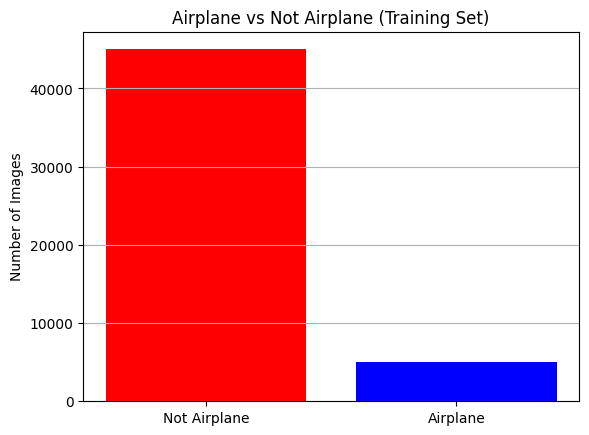

In [ ]:
labels = train_dataset.targets
classes, counts = np.unique(labels, return_counts=True)

plt.bar(['Not Airplane', 'Airplane'], counts, color=['red', 'blue'])
plt.title('Airplane vs Not Airplane (Training Set)')
plt.ylabel('Number of Images')
plt.grid(axis='y')
plt.show()

<i>Class imbalance in the training set: 'Airplane' vs 'Not Airplane'. Only 5 000 of 50 000 training images are airplanes, while 45 000 images are other objects (animals, vehicles, etc.), making accuracy alone misleading. 


This imbalance poses the challenge that the model could naively predict every image as 'Not Airplane' and be correct 90% of the time, eventhough it failed to predict any airplanes. In fact, accuracy can be a misleading metric on imbalanced data, as it may reflect the dominant class frequently (Akosa, 2017). To address this, we need to ensure our model pays attention to the minority class. We will do so by using a weighted loss function that harder punish mis classifications on the airplane class, than errors on non-airplane classes (Tantai, 2023). This way, mistakes in the rare class count more heavily, prompting the model to focus on detecting airplanes.


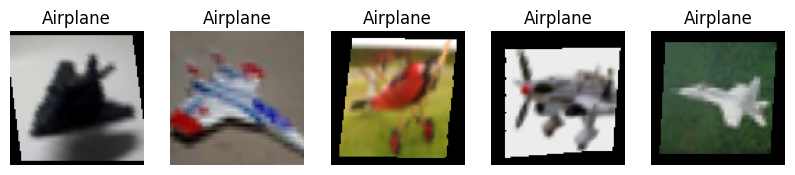

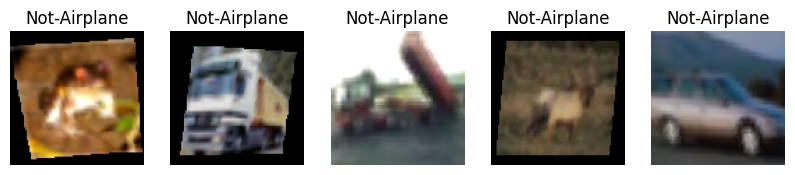

In [ ]:
def unnormalize(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)
    return img * std + mean

def show_images(dataset, label=1, n=5, title='Airplane' if 1 else 'Not-Airplane'):
    shown = 0
    plt.figure(figsize=(n*2, 2))
    i = 0
    while shown < n and i < len(dataset):
        img, lbl = dataset[i]
        if lbl == label:
            img = unnormalize(img)
            img = img.permute(1, 2, 0).numpy()
            plt.subplot(1, n, shown+1)
            plt.imshow(np.clip(img, 0, 1))
            plt.axis('off')
            plt.title(title)
            shown += 1
        i += 1
    plt.show()


show_images(train_dataset, label=1, title='Airplane')
show_images(train_dataset, label=0, title='Not-Airplane')

<i>This visualizes the two classes 'Airplane' & 'Not Airplane' and their different images. </i>

### MobileNetV2


Rather thain training a CNN from scratch, we use transfer learning with a pre-trained model. Transfer learning is rather popular becuase it allows us to build accurate models in an effective way (Marcelino, 2018). Transfer learning works by training a network on a big dataset like ImageNet and then using those weights as the initial weights in a new classification task (Shorten et al., 2019). In this task we have chosen to use MobileNetV2, a lightweight CNN trained on ImageNet, a dataset containing over one million images. By using MobileNetV2, we expect its early layers to already recognize basic image features that will help identify airplanes. 

In [ ]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
model.classifier[1]=nn.Linear(model.last_channel, 1)
model = model.to(device)

### Cross-entropy with logits

For training we have decided to use the Binary Cross-Entry logits loss function. This function is a loss function that combines a Sigmoid layer and the Binary Cross-Entropy loss function in one single class (PyTorch, n.d).

To account for class imbalance, we supply a positive class weight to the loss. We set positive weight = 9.0, reflecting that non-airplane images outnumber airplane images by roughly 9:1 in our training set. The idea is to make the model more sensitive to the airplane class by increasing cost of mis classification.

We trained the model using a learning rate of 0.0005 on 10 epochs using the adam optimizer. This value were selected based on a balance between good performance and training time. We chose not to freeze any layers in MobileNetV2, allowing the entire network to be fine-tuned on our binary clasification task. 

In [ ]:
positive_weight = torch.tensor([9.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=positive_weight)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

<a name='training_task3'></a>
### Training of the model

We train the model for 10 epochs and evaluate its performance the training set and the test set after each epoch. During training, we measure accuracy, precision, recall, and F1-score for the airplane class. These metrics gives us a clearer picture of performance on the airplane class. 

* Precision tells us what fraction of images predicted as airplanes were actually airplanes.

* Recall tells us what fraction of actual airplane images were actually airplanes. 

* F1-score is the harmonic mean of precision and recall. 

We track these because a high overall accuracy could be achieved by simply predicting 'not airplane' every time. 

In [ ]:
def train_model(model, train_loader, test_loader, epochs=5, name=None):
    train_acc, test_acc = [], []
    train_prec, test_prec = [], []
    train_rec, test_rec = [], []
    train_f1, test_f1 = [], []
    train_loss, test_loss = [], []

    for epoch in range(epochs):
        model.train()
        y_true, y_pred = [], []
        total_loss = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        train_acc.append(np.mean(np.array(y_true) == np.array(y_pred)) * 100)
        train_prec.append(precision_score(y_true, y_pred, zero_division=0))
        train_rec.append(recall_score(y_true, y_pred, zero_division=0))
        train_f1.append(f1_score(y_true, y_pred, zero_division=0))
        train_loss.append(total_loss/len(train_loader))

        # Validation
        model.eval()
        y_true, y_pred = [], []
        total_val_loss = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(imgs)
                loss=criterion(outputs, labels)
                total_val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        test_acc.append(np.mean(np.array(y_true) == np.array(y_pred)) * 100)
        test_prec.append(precision_score(y_true, y_pred, zero_division=0))
        test_rec.append(recall_score(y_true, y_pred, zero_division=0))
        test_f1.append(f1_score(y_true, y_pred, zero_division=0))
        test_loss.append(total_val_loss/len(test_loader))

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc[-1]:.2f}% | Test Acc: {test_acc[-1]:.2f}% | F1: {test_f1[-1]:.4f} | Loss: {test_loss[-1]:.4f}")
        scheduler.step()

    if name:
        df = pd.DataFrame({
            'epoch':list(range(1, epochs + 1)),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'train_prec': train_prec,
            'test_prec': test_prec,
            'train_rec': train_rec,
            'test_rec': test_rec,
            'train_f1': train_f1,
            'test_f1': test_f1
        })
        df.to_csv(f'{name}_metrics.csv', index=False)
        torch.save(model.state_dict(), f'{name}_model.pth')
            
train_model(model, train_loader, test_loader, 10, 'Finish')

Epoch 1/10 - Train Acc: 91.75% | Test Acc: 94.10% | F1: 0.7664 | Loss: 0.2250
Epoch 2/10 - Train Acc: 94.16% | Test Acc: 96.67% | F1: 0.8491 | Loss: 0.2308
Epoch 3/10 - Train Acc: 95.43% | Test Acc: 95.78% | F1: 0.8178 | Loss: 0.2233
Epoch 4/10 - Train Acc: 95.96% | Test Acc: 97.69% | F1: 0.8937 | Loss: 0.1426
Epoch 5/10 - Train Acc: 96.30% | Test Acc: 97.90% | F1: 0.9001 | Loss: 0.1943
Epoch 6/10 - Train Acc: 96.46% | Test Acc: 97.12% | F1: 0.8704 | Loss: 0.1573
Epoch 7/10 - Train Acc: 96.90% | Test Acc: 97.94% | F1: 0.9024 | Loss: 0.1576
Epoch 8/10 - Train Acc: 97.24% | Test Acc: 97.31% | F1: 0.8778 | Loss: 0.1465
Epoch 9/10 - Train Acc: 97.28% | Test Acc: 98.06% | F1: 0.9061 | Loss: 0.1920
Epoch 10/10 - Train Acc: 97.54% | Test Acc: 97.12% | F1: 0.8697 | Loss: 0.1731


After training for 10 epochs, our model achieves ~97% accuracy on the test set. More importantly, it achieves a high F1-score for the airplanes class, indicating a good balance of precision and recall. By the last epoch, the model's precision and recall for detecting airplanes are both high. This means the model successfully identifies the majority of airplane images while keeping false alarms low. In comparison, a naive model that always predict "not airplane" would get 90% accuracy, but 0% recall for airplanes. Out model clearly outperformes thris, detecting a large portion of airplanes. The training and validation loss decreased over epochs, and the accuracy and F1 steadily improved before leveling off, suggesting the model learned effectively without severe overfitting. 

We can slo see that the training and test accuracy stayed fairly close, both at mid 90% by epoch number 10. This implies that our data augmentation strategy succeeded in preventing overfitting. The weighted loss was particularly important, as the model could have predicted the non-airplane class every time for an easy 90% accuracy. By looking at the epochs, from number 1 through 10, the results confirms that the network genuinely is learning to recognize airplanes in images. 

<a name='graphs'></a>
### Graphs

To further illustrate the training progress, we tracked the metrics across epochs. The plot of accuracy over epochs showed both training and test accuray climbing intro the mid 90%. The F1-score for the airplane class increased each epoch, reflecting better balance between precision and recall under training. The loss curve declined epoch by epoch. Overall, the metrics demonstrate that our transfer-learned CNN quickly reached high performance on this airplane vs not ariplane classification task. 

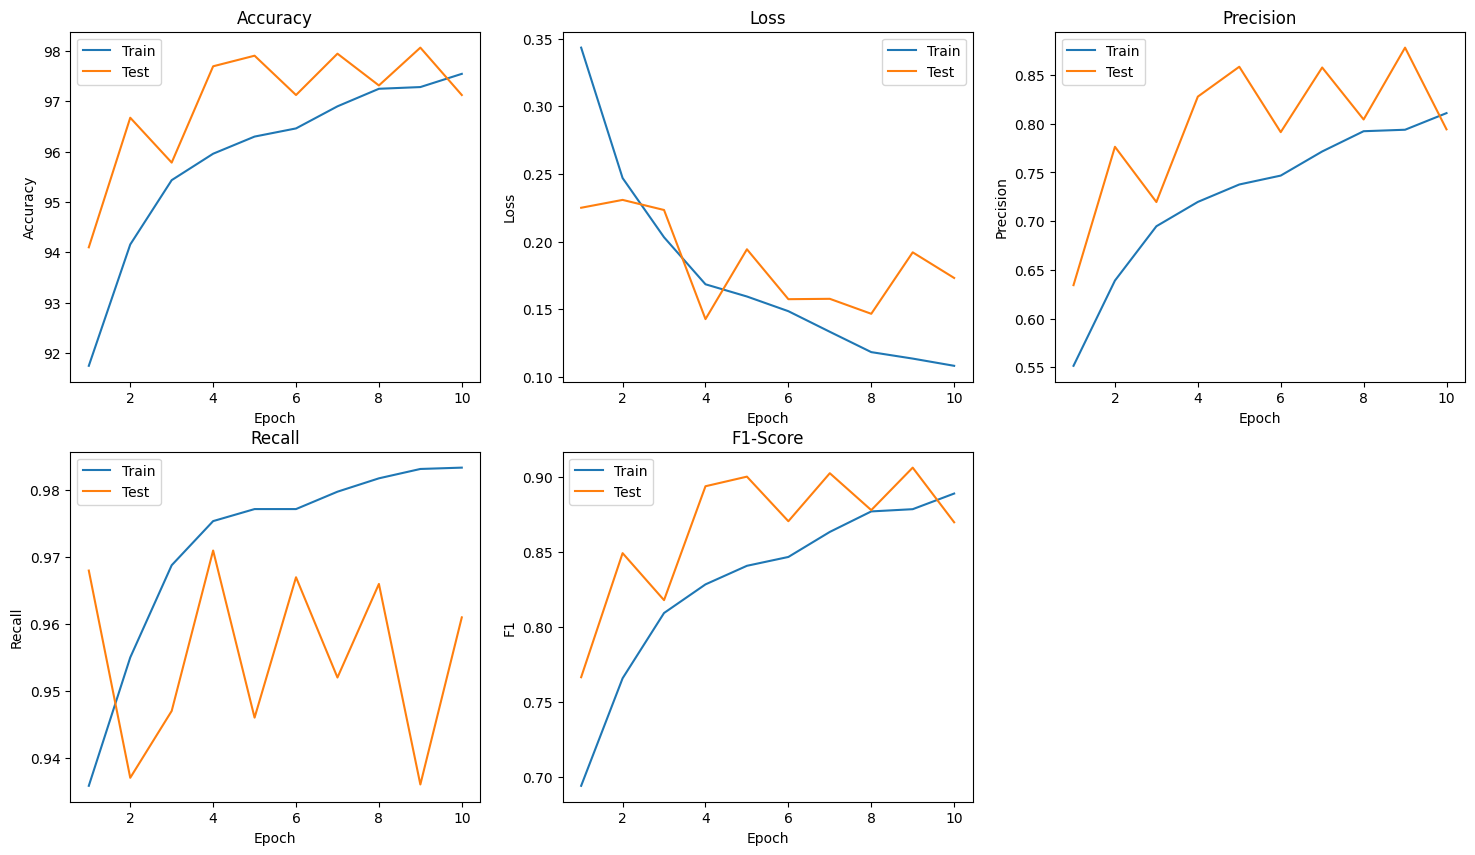

In [ ]:
df = pd.read_csv('Finish_metrics.csv')

plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.plot(df['epoch'], df['train_acc'], label='Train')
plt.plot(df['epoch'], df['test_acc'], label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(2, 3, 2)
plt.plot(df['epoch'], df['train_loss'], label='Train')
plt.plot(df['epoch'], df['test_loss'], label='Test')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(2, 3, 3)
plt.plot(df['epoch'], df['train_prec'], label='Train')
plt.plot(df['epoch'], df['test_prec'], label='Test')
plt.title('Precision')
plt.xlabel('Epoch'); plt.ylabel('Precision'); plt.legend()

plt.subplot(2, 3, 4)
plt.plot(df['epoch'], df['train_rec'], label='Train')
plt.plot(df['epoch'], df['test_rec'], label='Test')
plt.title('Recall')
plt.xlabel('Epoch'); plt.ylabel('Recall'); plt.legend()

plt.subplot(2, 3, 5)
plt.plot(df['epoch'], df['train_f1'], label='Train')
plt.plot(df['epoch'], df['test_f1'], label='Test')
plt.title('F1-Score')
plt.xlabel('Epoch'); plt.ylabel('F1'); plt.legend()


plt.show()

### Confusion Matrix

In [ ]:
def collect_preds(model, test_loader):
    y_true = []
    y_pred = []
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    return y_true, y_pred

def show_confusion_matrix_raw(y_true, y_pred, class_names=["Not Airplane", "Airplane"]):
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=class_names,
        cmap="Blues",
        normalize=None, 
        values_format='d'
    )
    plt.title("Confusion Matrix – Number of Images")
    plt.tight_layout()
    plt.show()  

def show_confusion_matrix_normalized(y_true, y_pred, class_names=["Not Airplane", "Airplane"]):
    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred,
        display_labels=class_names,
        cmap="Blues",
        normalize='true', 
        values_format='.1%' 
    )
    plt.title("Normalized Confusion Matrix – Percent per Class")
    plt.tight_layout()
    plt.show()

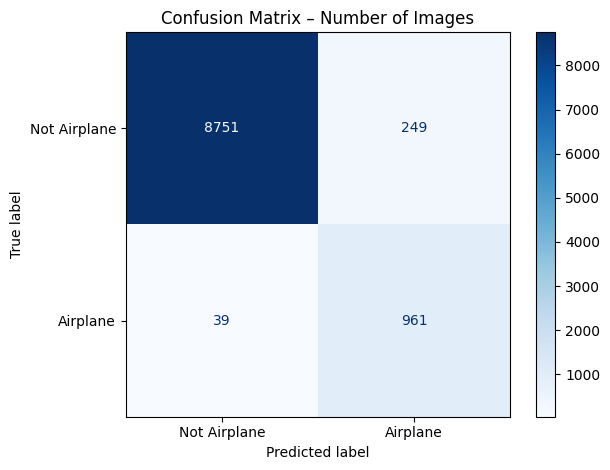

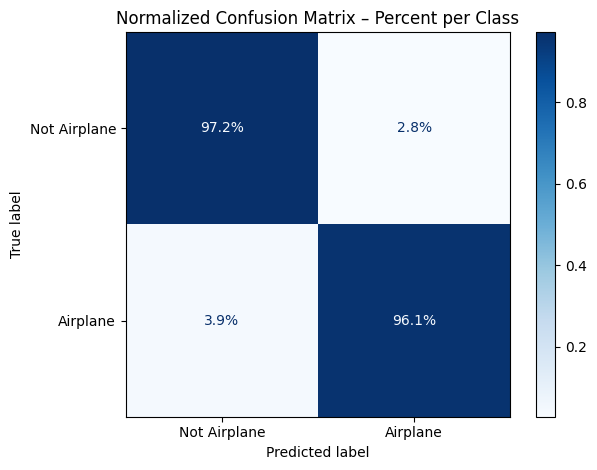

In [ ]:
y_true, y_pred = collect_preds(model, test_loader)

show_confusion_matrix_raw(y_true, y_pred)
show_confusion_matrix_normalized(y_true, y_pred)

The top confusion matrix shows how many images are being predicted correctly airplane an not airplane. The confusion matrix below shows us a more tangible number, as it shows how many images are predicted correct and not in percentage of the class. The confusion matrix shows that the model classifies correctly in ~96/97% of the images. 

<a name='task2b'></a>
## Task 2 b. Predicting images

With the trained model, we can use it to predict new 'unseen' images. We define a helper function that loads and image file, applies the same preprocessing as our training data, and then runs our trained network to get a prediction. We also attach a confidence score for the prediction. 


In [ ]:
def predict_image(image_path, model_path='Finish_model.pth'):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    model.classifier[1] = torch.nn.Linear(model.last_channel, 1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform_test(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        prob = torch.sigmoid(output).item()

    label = "Airplane" if prob > 0.5 else "Not Airplane"
    confidence = prob * 100 if prob > 0.5 else (1 - prob) * 100

    plt.imshow(image)
    plt.axis()
    plt.title(f"{label} ({confidence:.2f}% confidence)", fontsize=14, color='navy')
    plt.show()

    return label, confidence

We load the trained model from the saved weights. The image is opened with PIL and cinverted to RGB, then fed through the same normalization pipeline as our training images. The model's output probability represents the confidence that the image is an airplane. Using this fucntion, we tested our model on a variety of images:


#### Example 1: Dog


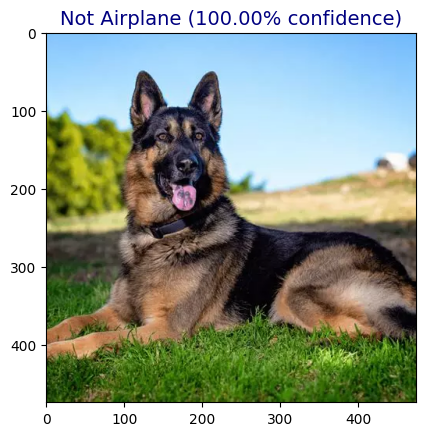

('Not Airplane', 99.99991297122506)

In [ ]:
predict_image('my_dog.jpg')

An image of a dog was predicted as 'Not Airplane' with over 99% confidence. <b>Good</b>, as the dog is indeed not an airplane. 


#### Example 2: Frog


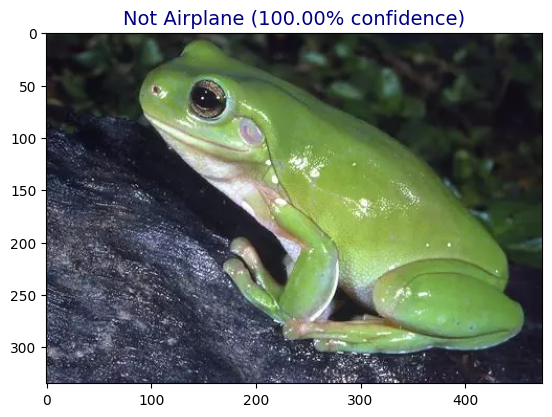

('Not Airplane', 99.99872758553465)

In [ ]:
predict_image('frog.webp')

An image of a frog predicted 'Not Airplane' with over 99% confidence. Same as the dog, <b><i>very</i> good</b>.


#### Example 3: Plane with mountain background


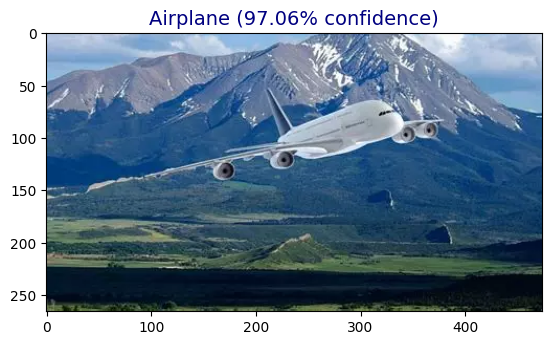

('Airplane', 97.05506563186646)

In [ ]:
predict_image('airplane_1.webp')

An image of an airplane flying in front of a mountain range was predicted 'Airplane' with 97% confidence. Proving that the model can successfully recognize airplanes. 


#### Example 4: Bombardino Crocodilo


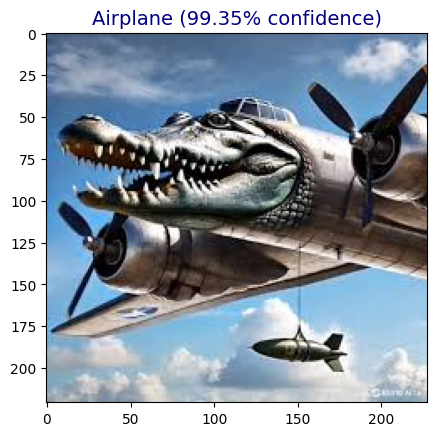

('Airplane', 99.35264587402344)

In [ ]:
predict_image('croc_bomb.jpeg')

We even tried an image of the popular internet 'brainrot' meme, Bombardino Crocodilo. This AI Crocodile-faced airplane was predicted as an airplane with 99% confidence. 


## Conclusion

In conclusion, we successfully trained a convolutional neural network to detect airplanes in the CIFAR-10 dataset using transfer learning. By employing data augmentation and a pre-trained MobileNetV2 model, we achievced robust performance with 10 training epochs. The model reached approximately 96% accuracy on the test set and was also able to correctly identify roughly 85-90% of airplanes images (high recall), while also showing high precision mislabeling very few non-airplanes as airplanes. This was accomplished by addressing the big class imbalance and applying a weighted loss to make the model focus on the minority airplane-class. We also tracked the F1-score during training to ensure balanced improvements. The result is an image classifier that reliably distinguishes airplanes form the other objects in the images. 


## Sources

* Akosa, J, S. (2017). <i>Predictive accuracy: A Misleading Performance Measure for Highly Imbalanced Data</i> [Online]. Oklahoma State University. Available at: https://support.sas.com/resources/papers/proceedings17/0942-2017.pdf

* Awan, A. A. 2024. A Complete Guide to Data Augmentation [Online]. Datacamp. Available at: https://www.datacamp.com/tutorial/complete-guide-data-augmentation

* Bhadoria, V. (2020). <i>Cifar10 high accuracy model on PyTorch</i> [Online]. Kaggle. Available at: https://www.kaggle.com/code/vikasbhadoria/cifar10-high-accuracy-model-build-on-pytorch/notebook

* Krizhevsky, A. (2009). <i>Learning Multiple Layers of Feautures from Tiny Images</i> [Online]. University of Toronto. Available at: https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

* Marcelino, P. (2018). <i>Transfer learning from pre-trained models</i>[Online]. Medium. Available at: https://medium.com/data-science/transfer-learning-from-pre-trained-models-f2393f124751 

* Shorten, C., & Khoshgoftaar, T. M. (2019). A Survey on Image Data Augmentation for Deep Learning [Online]. <i>Journal of Big Data</i>, 6(1), 60. Available at: https://doi.org/10.1186/s40537-019-0197-0

* Tantai, H. (2023, May 23). <i>Use weighted loss function to solve imbalanced data classification problems</i> [Online]. Medium. Available at: https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75

* Zahra. (2021, June 24). <i>How to calculate the mean and the std of cifar10 data</i> [Online]. Stack overflow. https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data? 